# **Final Project for CSCN8010 Foundations of Machine Learning Frameworks** 

## **Predicting Preferences for Mental Health Care: A Machine Learning Approach**

Mental health is a critical aspect of overall well-being, yet access to and utilization of professional care services can be limited. Understanding individuals' attitudes and preferences towards seeking professional help is key to improving mental health outcomes.<br/> This project leverages machine learning to predict whether an individual might consider or prefer professional care for mental health concerns based on demographic and behavioral factors.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load the CSV file into a pandas DataFrame
df = pd.read_csv('C:/Users/vishv/OneDrive/Documents/AIML/ML_Framework/CSCN8010-Mycopy/data/Mental Health Dataset.csv')
df.head()

,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
0,8/27/2014 11:29,Female,United States,Corporate,NaN,No,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Not sure
1,8/27/2014 11:31,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,No
2,8/27/2014 11:32,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
3,8/27/2014 11:37,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Yes
4,8/27/2014 11:43,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes


### **EDA** - Some Data about our data

In [ ]:
df.describe()

,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
count,292364,292364,292364,292364,287162,292364,292364,292364,292364,292364,292364,292364,292364,292364,292364,292364,292364
unique,580,2,35,5,2,2,2,5,3,3,3,3,2,3,3,3,3
top,8/27/2014 11:43,Male,United States,Housewife,No,No,Yes,1-14 days,Maybe,Yes,No,Medium,No,No,Maybe,No,No
freq,2384,239850,171308,66351,257994,176832,147606,63548,99985,109523,104018,101064,154328,105843,103393,232166,118886


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292364 entries, 0 to 292363
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Timestamp                292364 non-null  object
 1   Gender                   292364 non-null  object
 2   Country                  292364 non-null  object
 3   Occupation               292364 non-null  object
 4   self_employed            287162 non-null  object
 5   family_history           292364 non-null  object
 6   treatment                292364 non-null  object
 7   Days_Indoors             292364 non-null  object
 8   Growing_Stress           292364 non-null  object
 9   Changes_Habits           292364 non-null  object
 10  Mental_Health_History    292364 non-null  object
 11  Mood_Swings              292364 non-null  object
 12  Coping_Struggles         292364 non-null  object
 13  Work_Interest            292364 non-null  object
 14  Social_Weakness     

Total null values in each column,

In [ ]:
df.isnull().sum()

Timestamp                     0
Gender                        0
Country                       0
Occupation                    0
self_employed              5202
family_history                0
treatment                     0
Days_Indoors                  0
Growing_Stress                0
Changes_Habits                0
Mental_Health_History         0
Mood_Swings                   0
Coping_Struggles              0
Work_Interest                 0
Social_Weakness               0
mental_health_interview       0
care_options                  0
dtype: int64

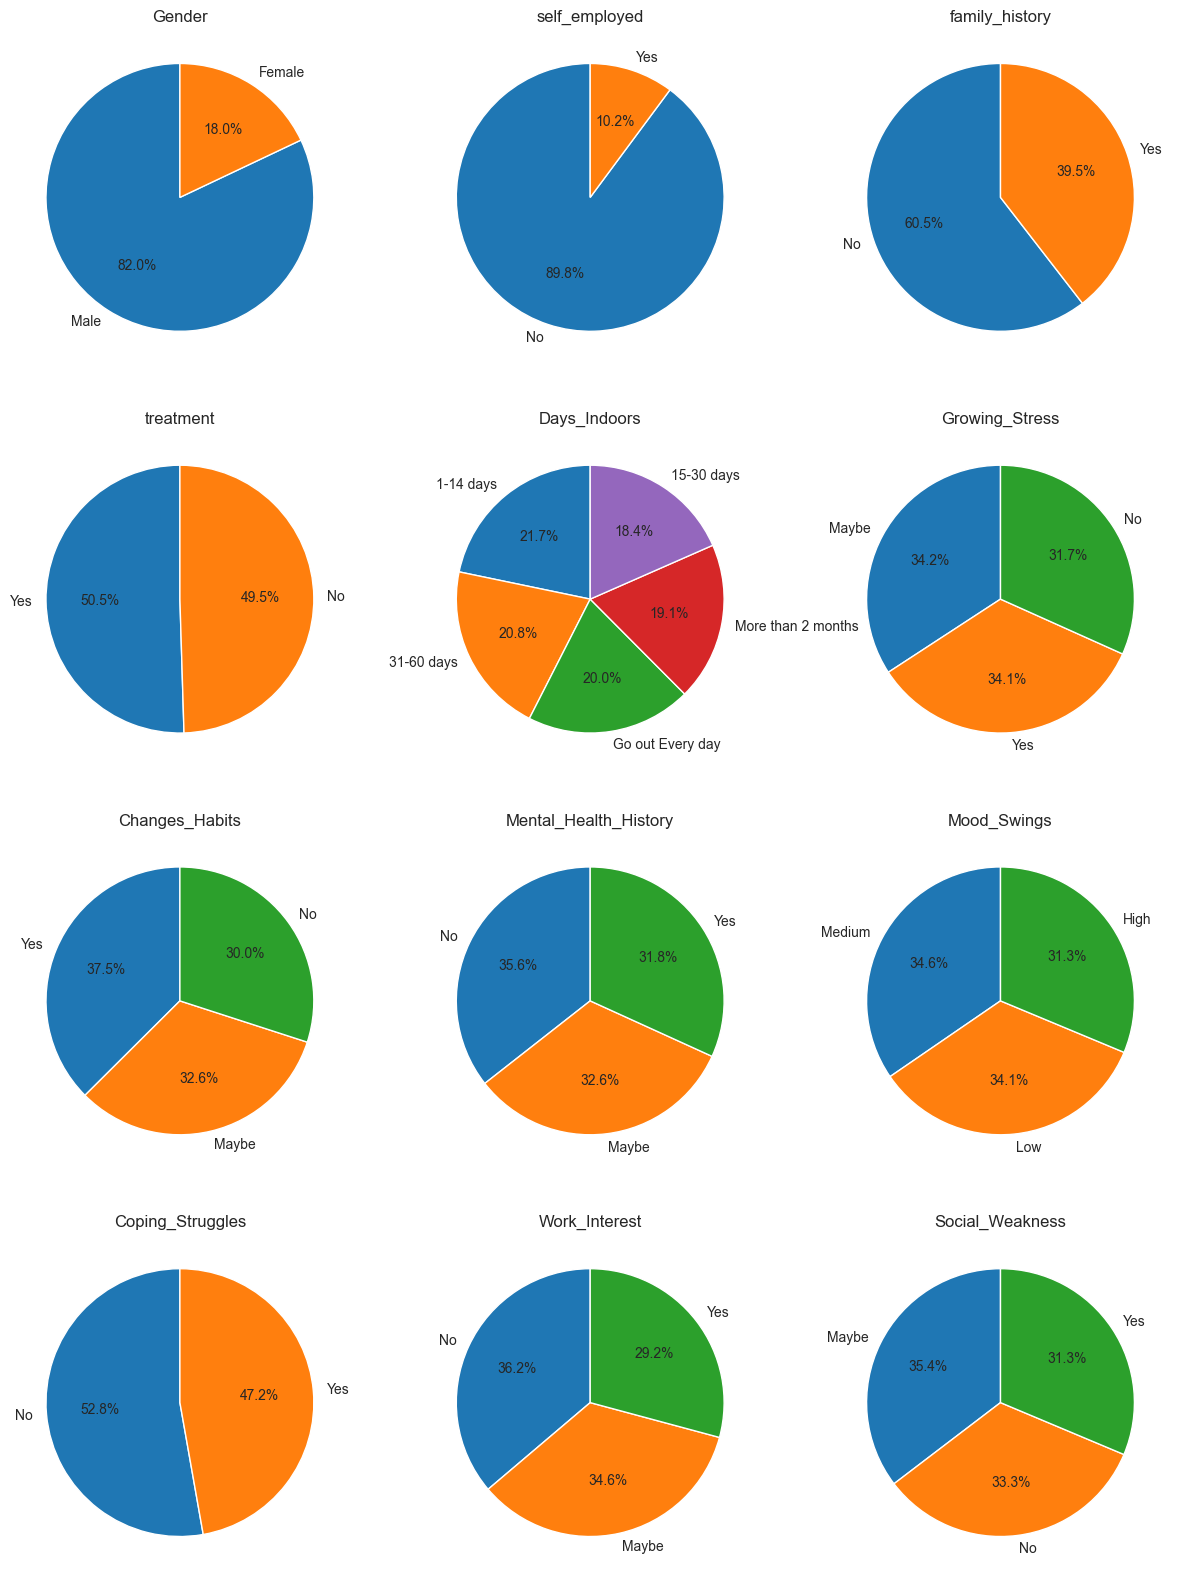

In [ ]:
sns.set_style("whitegrid")

cols_to_visualize = ['Gender', 'self_employed','family_history', 'treatment', 'Days_Indoors', 'Growing_Stress','Changes_Habits', 'Mental_Health_History', 'Mood_Swings','Coping_Struggles', 'Work_Interest', 'Social_Weakness']
counts = []

for col in cols_to_visualize:
    counts.append(df[col].value_counts())
    
fig, axs = plt.subplots(4, 3, figsize=(15, 20))
axs = axs.flatten()

for i, (col, count) in enumerate(zip(cols_to_visualize, counts)):
    axs[i].pie(count, labels=count.index, autopct='%1.1f%%', startangle=90)
    axs[i].set_title(col)
    

plt.show()

[Refrence](https://www.kaggle.com/code/andreistefaniosup/mental-health-dataset-eda)

### Insights:

* **Mental health history:** The data is split between two categories: with a history of mental health issues (31.6%), without a history(35.6%) and those are not sure(32.6%).
* **Treatment factors:** There are multiple pie charts here. Each chart shows a breakdown of individuals who received treatment in the past (50.5%) compared to those who did not receive treatment(49.5%). 
* **Days indoors:** The data is almost equally divided into 5 categories for the number of days spent indoors (e.g., every day, less than a month, more than 2 months).
* **Changes in habits:** More than 37% of people have changed thier habits.
* **Work interest:** Similar to days indoors, these are divided into categories like "interested in work," "neutral about work," and "not interested in work." Only 29% of responders are interested in work, those who are not interested and unsure take of equal space of the remainder.

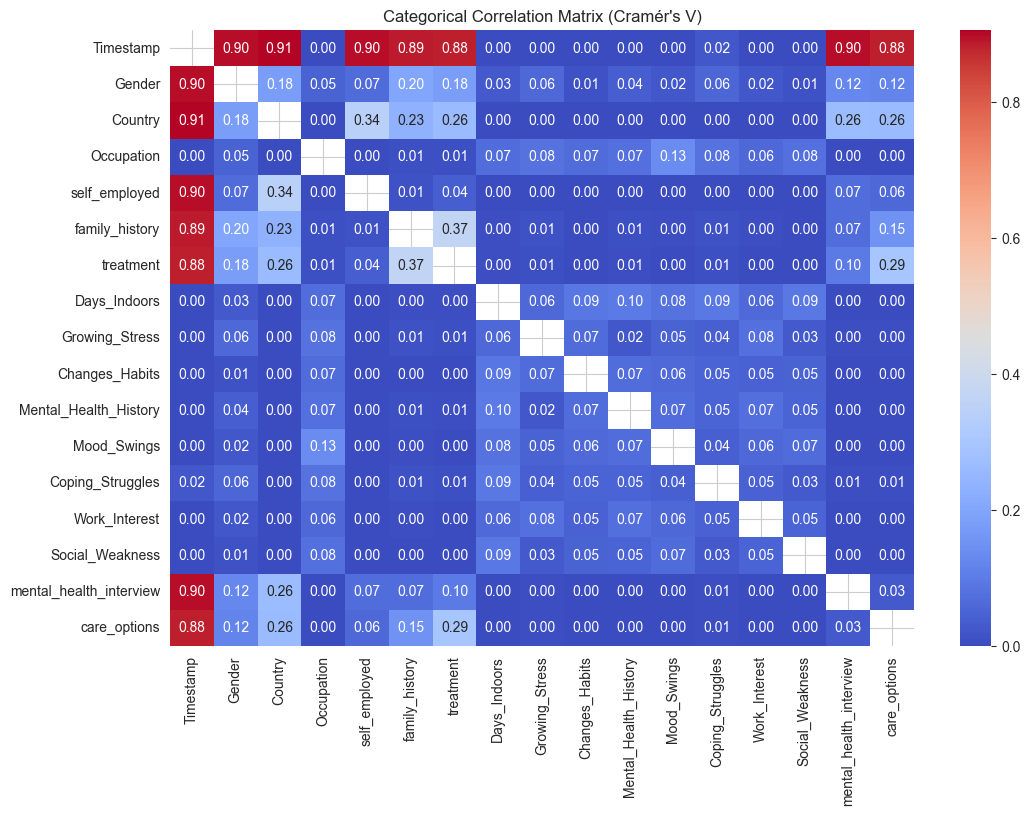

In [ ]:
from scipy.stats import chi2_contingency

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Assuming df_cleaned is your DataFrame
categorical_cols = df.columns.tolist()

# Calculate Cramér's V for pairs of categorical variables
categorical_correlation_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 != col2:
            confusion_matrix = pd.crosstab(df[col1], df[col2])
            categorical_correlation_matrix.loc[col1, col2] = cramers_v(confusion_matrix)

# Convert correlation matrix to numeric values
categorical_correlation_matrix = categorical_correlation_matrix.apply(pd.to_numeric)

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(categorical_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Categorical Correlation Matrix (Cramér's V)")
plt.show()


[Refrence](https://www.kaggle.com/code/andreistefaniosup/mental-health-dataset-eda)

Here are some specific observations from the matrix:

**Strong correlations (0.8 or higher):**
Timestamp and mental_health interview (0.90)<br/>
Timestamp and care_options (0.88)<br/>
Gender and self_employed (0.90)<br/>
Country and care_options (0.80)<br/>
Family_history and treatment (0.60)<br/><br/>
**Moderate correlations (0.5 to 0.79):**<br/>
Gender and treatment (0.50)<br/>
Country and self_employed (0.34)<br/>
Occupation and self_employed (0.34)<br/>
Mental_Health_History and treatment (0.37)<br/><br/>
**Weak correlations (0.2 to 0.49):**<br/>
Several variables exhibit weak correlations with each other, ranging from 0.20 to 0.49.

# **Preprocessing**

In [ ]:
df.dropna(inplace=True)

* Binary Variables are encoded using label encoding to convert the data into numeric values.

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df["Gender"] = le.fit_transform(df["Gender"])
df["self_employed"] = le.fit_transform(df["self_employed"])
df["family_history"] = le.fit_transform(df["family_history"])
df["treatment"] = le.fit_transform(df["treatment"])
df["Coping_Struggles"] = le.fit_transform(df["Coping_Struggles"])

* Categorical Variables are encoded using one-hot encoding, which is used for variables do not have any inherent order.

In [ ]:
data = pd.get_dummies(data=df, columns=["Occupation", "Days_Indoors", "Growing_Stress",
            "Changes_Habits", "Mental_Health_History", "Work_Interest", "Social_Weakness",
            "mental_health_interview", "Mood_Swings"])

data = pd.get_dummies(data=data, columns=["care_options"])

* As it is just the record of time and date when the data was collected, we will drop this column.

In [ ]:
data.drop("Timestamp", axis=1, inplace=True)

In [ ]:
from category_encoders import LeaveOneOutEncoder

leave_encoder = LeaveOneOutEncoder()
data["Country"] = leave_encoder.fit_transform(data["Country"], data.iloc[:, -3])

In [ ]:
data.head()

,Gender,Country,self_employed,family_history,treatment,Coping_Struggles,Occupation_Business,Occupation_Corporate,Occupation_Housewife,Occupation_Others,...,Social_Weakness_Yes,mental_health_interview_Maybe,mental_health_interview_No,mental_health_interview_Yes,Mood_Swings_High,Mood_Swings_Low,Mood_Swings_Medium,care_options_No,care_options_Not sure,care_options_Yes
3,0,0.332713,0,1,1,0,False,True,False,False,...,True,True,False,False,False,False,True,False,False,True
4,0,0.332713,0,1,1,0,False,True,False,False,...,True,False,True,False,False,False,True,False,False,True
5,0,0.473876,0,0,1,0,False,True,False,False,...,True,True,False,False,False,False,True,False,True,False
6,0,0.266224,0,1,1,0,False,True,False,False,...,True,False,True,False,False,False,True,False,True,False
7,0,0.332707,0,0,0,0,False,True,False,False,...,True,False,True,False,False,False,True,True,False,False


Splitting the dataset into training set and test set,

In [ ]:
X = data.drop(data.iloc[:, -3:], axis=1)
y = data.iloc[:, -3:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (201013, 37)
Shape of y_train: (201013, 3)
Shape of X_test: (86149, 37)
Shape of y_test: (86149, 3)


### **Logistic Regression**

In [ ]:
# Create a logistic regression model
logistic_regression_model = LogisticRegression()

# Initialize lists to store accuracy
accuracy_list_lr = []

# Create a MultiOutputClassifier with logistic regression model
lr_multi_class = MultiOutputClassifier(logistic_regression_model)

# Iterate over each target variable in the dataset
for i in data.iloc[:, -3:]:
    # Fit the MultiOutputClassifier on training data
    lr_multi_class.fit(X_train, y_train[[i]])
    
    # Make predictions on the test data
    y_pred_lr = lr_multi_class.predict(X_test)
    
    # Calculate accuracy for each target variable
    accuracy_lr = accuracy_score(y_test[i], y_pred_lr)
    
    # Append the scores to the respective lists
    accuracy_list_lr.append(accuracy_lr)

# Create DataFrames to store the scores
accuracy_lr_df = pd.DataFrame(accuracy_list_lr, columns=["accuracy"])

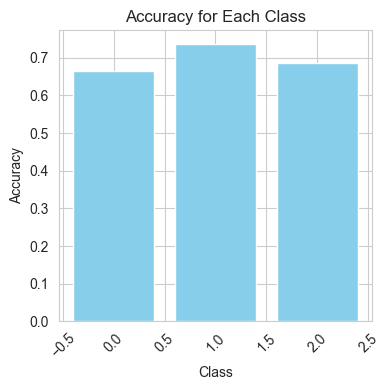

In [ ]:
# Get the class names (column names)
class_names = accuracy_lr_df.index

# Plot the bar plot
plt.figure(figsize=(4, 4))
plt.bar(class_names, accuracy_lr_df["accuracy"], color='skyblue')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Class')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


Confusion matrix for care_options_No:
[[44184  7049]
 [21739 13177]]

Classification report for care_options_No:
              precision    recall  f1-score   support

       False       0.67      0.86      0.75     51233
        True       0.65      0.38      0.48     34916

    accuracy                           0.67     86149
   macro avg       0.66      0.62      0.62     86149
weighted avg       0.66      0.67      0.64     86149



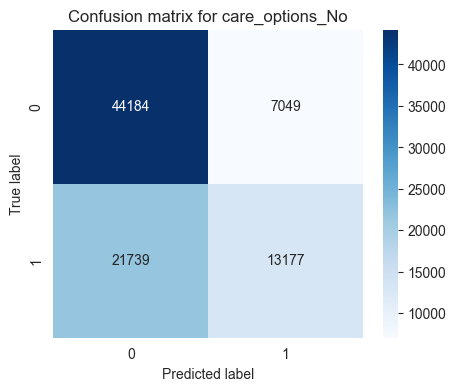

Confusion matrix for care_options_Not sure:
[[63135   244]
 [22523   247]]

Classification report for care_options_Not sure:
              precision    recall  f1-score   support

       False       0.74      1.00      0.85     63379
        True       0.50      0.01      0.02     22770

    accuracy                           0.74     86149
   macro avg       0.62      0.50      0.43     86149
weighted avg       0.68      0.74      0.63     86149



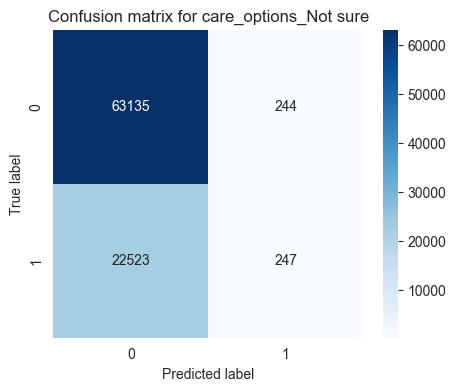

Confusion matrix for care_options_Yes:
[[50726  6960]
 [20072  8391]]

Classification report for care_options_Yes:
              precision    recall  f1-score   support

       False       0.72      0.88      0.79     57686
        True       0.55      0.29      0.38     28463

    accuracy                           0.69     86149
   macro avg       0.63      0.59      0.59     86149
weighted avg       0.66      0.69      0.66     86149



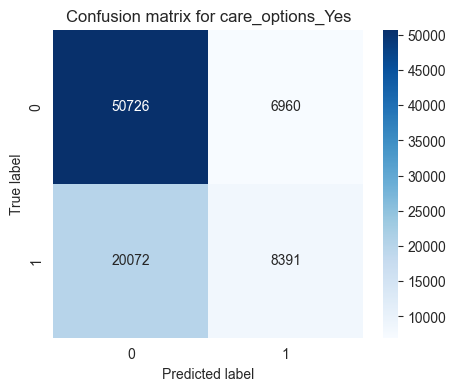

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Initialize lists to store confusion matrices and classification reports
confusion_matrices_lr = []
classification_reports_lr = []

# Iterate over each target variable in the dataset
for i in data.iloc[:, -3:]:  
    # Calculate confusion matrix and classification report for each target variable
    cm_lr = confusion_matrix(y_test[i], y_pred_lr)
    cr_lr = classification_report(y_test[i], y_pred_lr)
    
    # Append the confusion matrix and classification report to the respective lists
    confusion_matrices_lr.append(cm_lr)
    classification_reports_lr.append(cr_lr)

# Print confusion matrices and classification reports for each target variable
for i, target_variable in enumerate(data.iloc[:, -3:].columns):
    print(f"Confusion matrix for {target_variable}:")
    print(confusion_matrices_lr[i])
    print(f"\nClassification report for {target_variable}:")
    print(classification_reports_lr[i])

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrices_lr[i], annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion matrix for {target_variable}")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()


### **Care_options_No (Don't Need Care):**
* Accuracy: The model has a moderate accuracy (67%) in classifying individuals who likely don't require professional care.
* Better at predicting negatives: The model is better at identifying those who likely don't need care (precision: 0.67) compared to correctly identifying those who actually don't need care (recall: 0.38). This means the model might miss some true negatives.
* Room for improvement: The F1-score (0.48) indicates there's space for improvement in accurately classifying both true positives and negatives.<br/><br/>
### **Care_options_Not Sure (Undecided):**
* High False Negatives: The model struggles to identify individuals who are unsure about needing care (recall: 0.01). This means the model often misclassifies them as not needing care (False Positives: very high at 1.00).
* Limited Usefulness: Due to the very low recall, the model's predictions for "Not Sure" cases might not be reliable.<br/><br/>
### **Care_options_Yes (Need Care):**
* Moderate Accuracy: The model has a moderate accuracy (69%) in classifying individuals who likely require professional care.
* Similar to "No" category: The model shows a similar trend to the "No" category, with better precision (0.72) than recall (0.29). This suggests the model might miss some true positives (those who actually need care).
* F1-score reflects the trade-off: The F1-score (0.38) reflects a balance between precision and recall, indicating room for improvement in accurate classification for "Yes" cases.
Overall Model Performance:

### **Random Forest Classifier**

In [ ]:
# Create a random forest classifier model
random_forest_model = RandomForestClassifier(n_estimators=100)

# Initialize lists to store accuracy
accuracy_list_rf = []

# Create a MultiOutputClassifier with random forest model
rf_multi_class = MultiOutputClassifier(random_forest_model, n_jobs=-1)

# Iterate over each target variable in the dataset
for i in data.iloc[:, -3:]:
    # Fit the MultiOutputClassifier on training data
    rf_multi_class.fit(X_train, y_train[[i]])
    
    # Make predictions on the test data
    y_pred_rf = rf_multi_class.predict(X_test)
    
    # Calculate accuracy for each target variable
    accuracy = accuracy_score(y_test[i], y_pred_rf)
    
    # Append the scores to the respective lists
    accuracy_list_rf.append(accuracy)

# Create DataFrames to store the scores
accuracy_rf_df = pd.DataFrame(accuracy_list_rf, columns=["accuracy"])


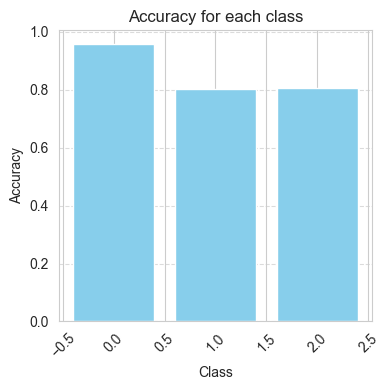

In [ ]:
import matplotlib.pyplot as plt

# Extract class labels from the DataFrame index
class_labels = accuracy_rf_df.index.tolist()

# Extract accuracy values from the DataFrame
accuracy_values = accuracy_rf_df["accuracy"].tolist()

# Plot the accuracy for each class
plt.figure(figsize=(4, 4))
plt.bar(class_labels, accuracy_values, color='skyblue')
plt.title('Accuracy for each class')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



Classification report for care_options_No:
              precision    recall  f1-score   support

       False       0.95      0.97      0.96     51233
        True       0.96      0.93      0.94     34916

    accuracy                           0.95     86149
   macro avg       0.95      0.95      0.95     86149
weighted avg       0.95      0.95      0.95     86149



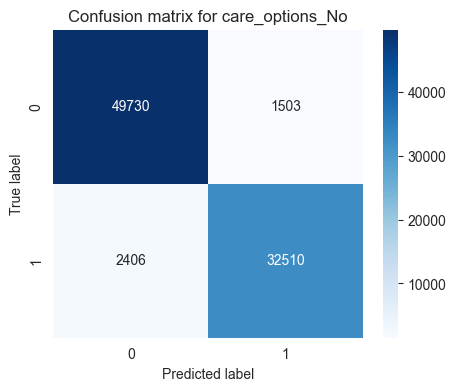


Classification report for care_options_Not sure:
              precision    recall  f1-score   support

       False       0.86      0.88      0.87     63379
        True       0.63      0.60      0.62     22770

    accuracy                           0.80     86149
   macro avg       0.75      0.74      0.74     86149
weighted avg       0.80      0.80      0.80     86149



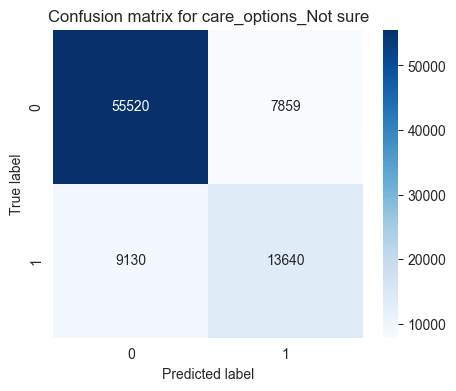


Classification report for care_options_Yes:
              precision    recall  f1-score   support

       False       0.85      0.86      0.86     57686
        True       0.71      0.70      0.71     28463

    accuracy                           0.81     86149
   macro avg       0.78      0.78      0.78     86149
weighted avg       0.81      0.81      0.81     86149



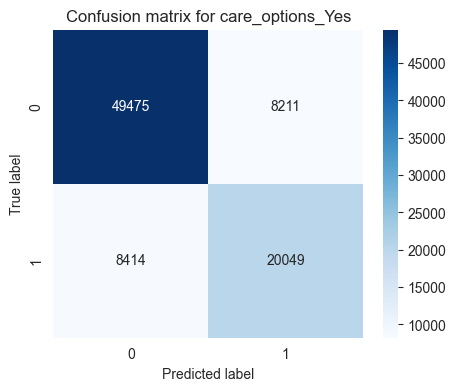

In [ ]:
# Initialize lists to store confusion matrices and classification reports
confusion_matrices_rf = []
classification_reports_rf = []

# Iterate over each target variable in the dataset
for i in data.iloc[:, -3:]:
    
    # Calculate confusion matrix and classification report for each target variable
    cm_rf = confusion_matrix(y_test[i], y_pred_rf)
    cr_rf = classification_report(y_test[i], y_pred_rf)
    
    # Append the confusion matrix and classification report to the respective lists
    confusion_matrices_rf.append(cm_rf)
    classification_reports_rf.append(cr_rf)

# Print confusion matrices and classification reports for each target variable
for i, target_variable in enumerate(data.iloc[:, -3:].columns):
    print(f"\nClassification report for {target_variable}:")
    print(classification_reports_rf[i])

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrices_rf[i], annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion matrix for {target_variable}")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()


* **Care_options_No (Don't Need Care):** The model performs very well here (accuracy: 95%) with a high ability to identify those who likely don't require professional help (precision and recall both around 95%).

* **Care_options_Not Sure (Undecided):** The model's performance is weaker for this category (accuracy: 80%). While it's good at identifying those who don't necessarily need care (high False negative rate), it struggles to pinpoint those who are unsure (lower recall and F1-score).

* **Care_options_Yes (Need Care):** Similar to the "Not Sure" category, the model shows moderate accuracy (81%) but has difficulty correctly classifying true positives (those who actually need care). The precision and recall scores are both around 70%.


### **Decision Tree**

In [ ]:
# Create a decision tree classifier model
decision_tree_model = DecisionTreeClassifier()

# Initialize lists to store accuracy
accuracy_list = []

# Create a MultiOutputClassifier with decision tree model
dt_multi_class = MultiOutputClassifier(decision_tree_model)

# Iterate over each target variable in the dataset
for i in data.iloc[:, -3:]:
    # Fit the MultiOutputClassifier on training data
    dt_multi_class.fit(X_train, y_train[[i]])
    
    # Make predictions on the test data
    y_pred_dt = dt_multi_class.predict(X_test)
    
    # Calculate accuracy for each target variable
    accuracy = accuracy_score(y_test[i], y_pred_dt)
    
    # Append the scores to the respective lists
    accuracy_list.append(accuracy)

# Create DataFrames to store the scores
accuracy_dt_df = pd.DataFrame(accuracy_list, columns=["accuracy"])


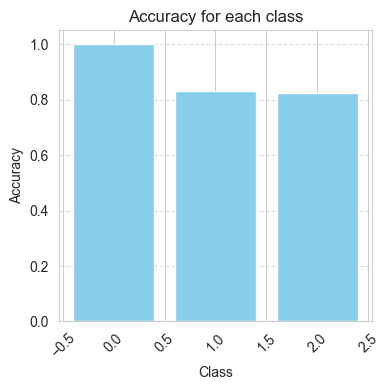

In [ ]:
# Extract class labels from the DataFrame index
class_labels = accuracy_dt_df.index.tolist()

# Extract accuracy values from the DataFrame
accuracy_values = accuracy_dt_df["accuracy"].tolist()

# Plot the accuracy for each class
plt.figure(figsize=(4, 4))
plt.bar(class_labels, accuracy_values, color='skyblue')
plt.title('Accuracy for each class')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



Classification report for care_options_No:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     51233
        True       1.00      1.00      1.00     34916

    accuracy                           1.00     86149
   macro avg       1.00      1.00      1.00     86149
weighted avg       1.00      1.00      1.00     86149



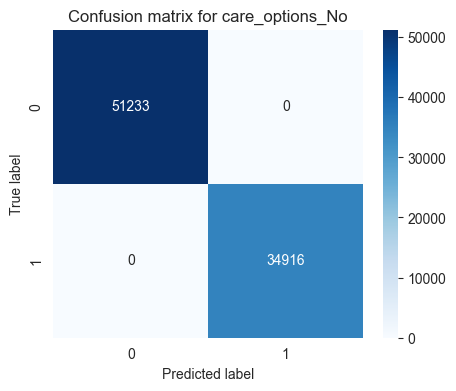


Classification report for care_options_Not sure:
              precision    recall  f1-score   support

       False       0.87      0.90      0.89     63379
        True       0.69      0.64      0.67     22770

    accuracy                           0.83     86149
   macro avg       0.78      0.77      0.78     86149
weighted avg       0.83      0.83      0.83     86149



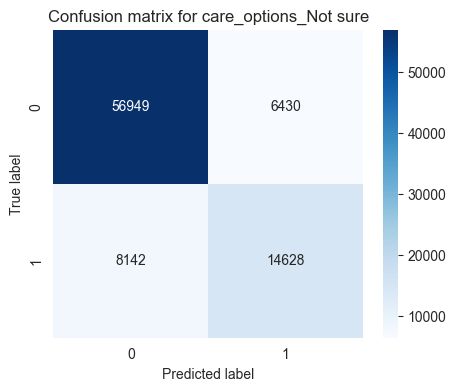


Classification report for care_options_Yes:
              precision    recall  f1-score   support

       False       0.86      0.88      0.87     57686
        True       0.74      0.72      0.73     28463

    accuracy                           0.83     86149
   macro avg       0.80      0.80      0.80     86149
weighted avg       0.82      0.83      0.82     86149



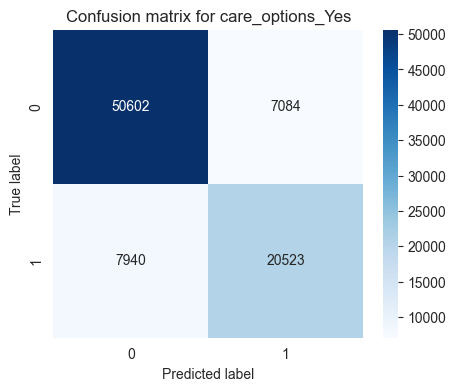

In [ ]:
# Initialize lists to store confusion matrices and classification reports
confusion_matrices_dt = []
classification_reports_dt = []

# Iterate over each target variable in the dataset
for i in data.iloc[:, -3:]:
   
    # Calculate confusion matrix and classification report for each target variable
    cm_dt = confusion_matrix(y_test[i], y_pred_dt)
    cr_dt = classification_report(y_test[i], y_pred_dt)
    
    # Append the confusion matrix and classification report to the respective lists
    confusion_matrices_dt.append(cm_dt)
    classification_reports_dt.append(cr_dt)

# Print confusion matrices and classification reports for each target variable
for i, target_variable in enumerate(data.iloc[:, -3:].columns):
    print(f"\nClassification report for {target_variable}:")
    print(classification_reports_dt[i])

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrices_dt[i], annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion matrix for {target_variable}")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()


* **Care_options_No (Don't Need Care):** Achieves a perfect score (1.00) in all metrics (precision, recall, F1-score, and accuracy). This indicates the model flawlessly identifies individuals who likely don't require professional care.

* **Care_options_Not Sure (Undecided):**
Shows good performance in identifying those who don't necessarily need care (high precision: 0.87).
However, it struggles to pinpoint those who are unsure about needing care (lower recall: 0.64 and F1-score: 0.67). This means the model might misclassify some undecided individuals as not needing care.

* **Care_options_Yes (Need Care):**
Similar to the "Not Sure" category, the model has moderate accuracy (0.83) but has difficulty correctly classifying all true positives (those who actually need care). The precision and recall scores are both around 70%.

### **Feed Forward Neural Network**

**We are doing 3 three things**
1. The data is standaedized by using a scalar to ensure all features are on a similar scale.
2. A sequential neural network with several hidden layers. The number of neurons in some layers is varied (done while fine tuning).
3. An early stopping callback to halt training if the validation loss fails to improve for five consecutive epochs. This helps prevent overfitting.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

# Normalize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the neural network model with a modified architecture
model = Sequential([
    Dense(512, activation='relu', input_dim=X_train_scaled.shape[1]),  # Increase the number of neurons
    Dense(256, activation='relu'),  # Add another hidden layer
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),  # Reduce the number of neurons
    Dense(128, activation='relu'), 
    Dense(64, activation='relu'),  
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),  
    Dense(3, activation='softmax')  # Output layer for multi-class classification
])

# Compile the model with a lower learning rate for Adam optimizer
optimizer = Adam(learning_rate=0.0001)  # Lower the learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with more epochs and a larger batch size
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=512, validation_data=(X_test_scaled, y_test), callbacks=[early_stopping])


Epoch 1/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4352 - loss: 1.0487 - val_accuracy: 0.5326 - val_loss: 0.9672
Epoch 2/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5261 - loss: 0.9606 - val_accuracy: 0.5317 - val_loss: 0.9497
Epoch 3/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5308 - loss: 0.9417 - val_accuracy: 0.5442 - val_loss: 0.9227
Epoch 4/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5471 - loss: 0.9102 - val_accuracy: 0.5507 - val_loss: 0.8919
Epoch 5/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5624 - loss: 0.8793 - val_accuracy: 0.5682 - val_loss: 0.8693
Epoch 6/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5694 - loss: 0.8592 - val_accuracy: 0.5762 - val_loss: 0.8549
Epoch 7/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5776 - loss: 0.8461 - val_accuracy: 0.5763 - val_loss: 0.8490
Epoch 8/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5804 - loss: 0.8391 - val_accuracy: 0.

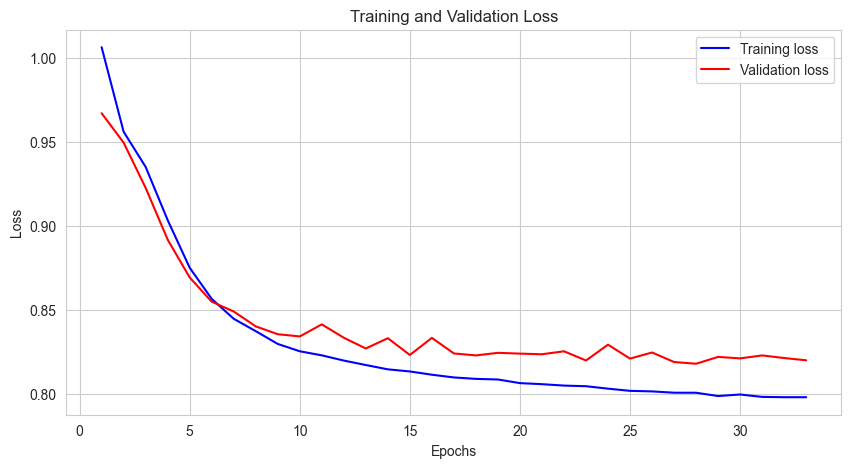

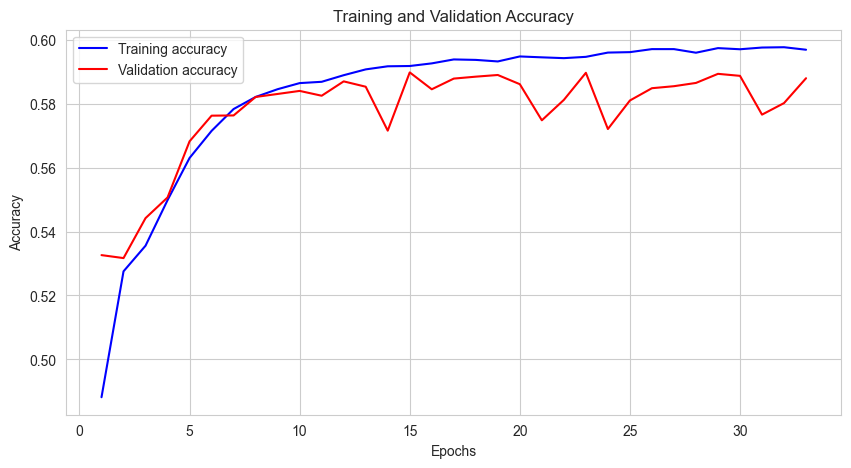

In [ ]:
# Get training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


* **Training Accuracy:** The training accuracy (indicated by "accuracy") generally increases over time, starting from 0.4352 and reaching 0.5991 by epoch 33. This suggests the network is gradually learning from the training data.

* **Validation Accuracy:** The validation accuracy (indicated by "val_accuracy") shows some fluctuations but remains around 0.58 throughout most epochs. This indicates the network is generalizing somewhat well to unseen data and avoiding overfitting to the training data.

* **Loss:** Both the training loss ("loss") and validation loss ("val_loss") decrease over time, suggesting the network is reducing its prediction errors.

However, we stop training after 5 epochs where val_loss is not decreasing significantly. Overall, the model performance is very poor

## **Conclusion**

* The basic **logistic regression** model has on average 70% accuracy in predicting different classes.
* The **descision tree** model gives the best average accuracy of more than 88%.
* So we tried a ensemble methos of trees, using the **Random Forest Classifier** we could achieve an average 85% accuracy, this suggest that model performs well and to further improve the accuracy we need to tune the hyper-parameters (which was not possible with our machines).
* Lastly the **Neural Network** we train performs poorly and achieves only 58% percent accuracy, this is due to the high dimensionality of the data.